## Langkah 1 : Persiapan Lingkungan Google Colab

In [1]:
# Instal library yang dibutuhkan
# langchain_community: Untuk integrasi yang mudah dengan berbagai LLM, termasuk Replicate. [cite: 21]
# replicate: Library Python untuk berinteraksi dengan API Replicate. [cite: 21]
# scikit-learn: Untuk metrik evaluasi model (classification_report, confusion_matrix).
# pandas, matplotlib, seaborn: Untuk manipulasi data, EDA, dan visualisasi.
# google.colab: Untuk mengakses secrets di Google Colab.
!pip install langchain_community replicate scikit-learn pandas matplotlib seaborn -q
!pip install accelerate -U -q # Untuk efisiensi GPU, meskipun tidak langsung di model lokal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/2

In [2]:
# Verifikasi Instalasi dan Ketersediaan GPU
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import userdata
from langchain_community.llms import Replicate
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(f"Versi PyTorch: {torch.__version__}")
print(f"CUDA (GPU) tersedia: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nama perangkat GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU tidak tersedia. Pastikan Anda sudah mengaktifkan runtime GPU.")

print("Lingkungan Colab siap!")

Versi PyTorch: 2.6.0+cu124
CUDA (GPU) tersedia: True
Nama perangkat GPU: Tesla T4
Lingkungan Colab siap!


## Langakah 2 : Memuat Dataset dan Eksplorasi Data Awal (EDA)

In [3]:
# Memuat dataset sesuai path
df = pd.read_csv('/content/Sentiment Analysis for Mental Health.csv')

In [4]:
# Melihat 5 baris dataset paling atas
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
# Melihat 5 baris dataset paling bawah
df.tail()

,Unnamed: 0,statement,status
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety
53042,53042,I have really bad door anxiety! It's not about...,Anxiety


In [6]:
# Melihat informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
# Melihat nilai unik pada setiap kolom dataset
df.nunique()

,0
Unnamed: 0,53043
statement,51073
status,7


In [8]:
# Mengecek apakah data nya ada missing values atau tidak
df.isnull().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [9]:
# Menghitung frekuensi kemunculan tiap nilai unik di kolom status.
df['status'].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


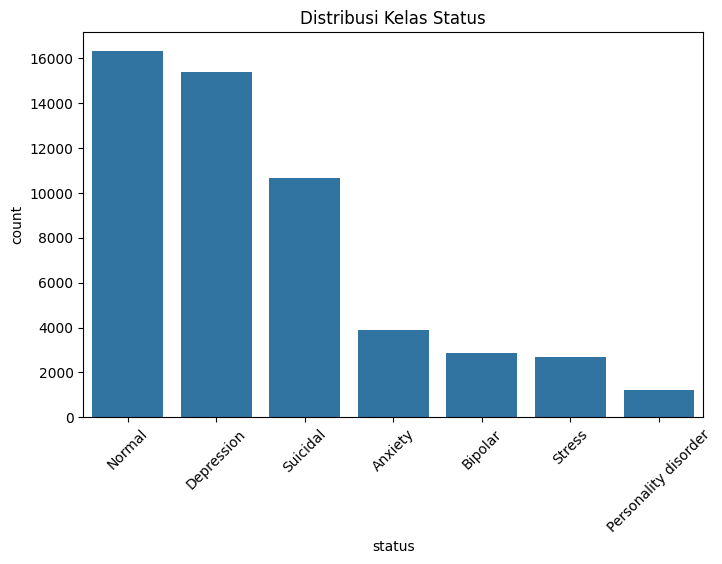

In [10]:
# Visualisasi distribusi jumlah data tiap kelas status (label)
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index)
plt.title('Distribusi Kelas Status')
plt.xticks(rotation=45)
plt.show()

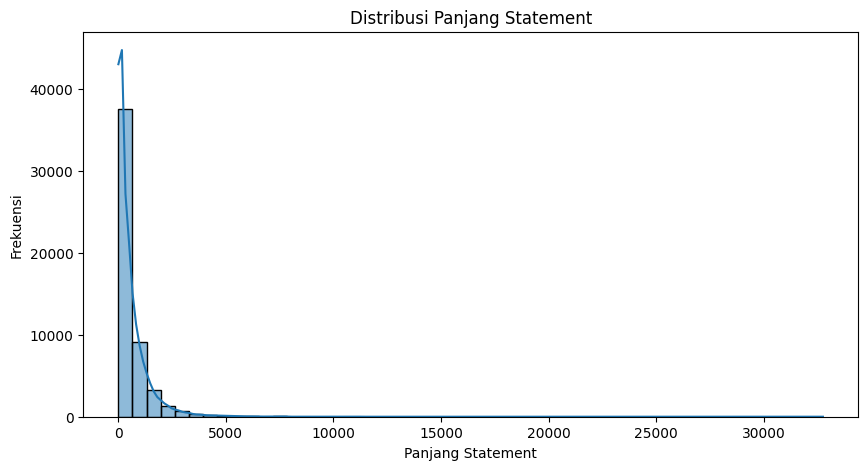

In [11]:
# Visualisasi distribusi panjang statement (fitur)
plt.figure(figsize=(10, 5))
sns.histplot(df['statement'].dropna().apply(len), bins=50, kde=True)
plt.title('Distribusi Panjang Statement')
plt.xlabel('Panjang Statement')
plt.ylabel('Frekuensi')
plt.show()

## Langkah 3 : Preprocessing Data (Pembersihan & Persiapan untuk Evaluasi)

In [12]:
# Penanganan missing values
initial_rows = len(df)
df.dropna(subset=['statement', 'status'], inplace=True)
df.reset_index(drop=True, inplace=True)
rows_after_dropna = len(df)
if initial_rows > rows_after_dropna:
    print(f"Ditemukan dan dihapus {initial_rows - rows_after_dropna} baris dengan missing values pada kolom krusial.")
else:
    print("Tidak ditemukan missing values pada kolom 'Statement' atau 'Mental Health Status'.")

Ditemukan dan dihapus 362 baris dengan missing values pada kolom krusial.


In [13]:
# Pemetaan Label (untuk evaluasi)
unique_labels = df['status'].unique().tolist()
unique_labels.sort()
label_to_id = {label: i for i, label in enumerate(unique_labels)}
id_to_label = {i: label for i, label in enumerate(unique_labels)}
print(f"\n--- Pemetaan Label ---")
print(f"Label ke ID: {label_to_id}")


--- Pemetaan Label ---
Label ke ID: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [14]:
# Split Dataset 80 untuk Training dan 20 Testing Set
X = df['statement']
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
print(f"\nUkuran Training Set: {len(X_train)}")
print(f"Ukuran Testing Set: {len(X_test)}")
print("\nPreprocessing data selesai. Dataset siap untuk prompting.")


Ukuran Training Set: 42144
Ukuran Testing Set: 10537

Preprocessing data selesai. Dataset siap untuk prompting.


## Langkah 4 : Persiapan Replicate API Token & Inisialisasi Model IBM Granite

In [16]:
# Ambil API Token dari Colab
try:
    replicate_api_token = userdata.get('api_token')
    os.environ["REPLICATE_API_TOKEN"] = replicate_api_token
    print("REPLICATE_API_TOKEN berhasil dimuat dari Colab Secrets.")
except Exception as e:
    print(f"[ERROR]: Gagal memuat REPLICATE_API_TOKEN dari Colab Secrets: {e}")
    raise Exception("REPLICATE_API_TOKEN tidak ditemukan atau tidak valid.")

REPLICATE_API_TOKEN berhasil dimuat dari Colab Secrets.


In [17]:
ibm_granite_model_id = "ibm-granite/granite-3.3-8b-instruct"

try:
    granite_llm = Replicate(
        model=ibm_granite_model_id,
        replicate_api_token=replicate_api_token,
        model_kwargs={
            "temperature": 0.1,  # Suhu rendah untuk klasifikasi agar deterministik.
            "max_new_tokens": 50, # Cukup untuk nama kategori.
        }
    )
    print(f"\nModel IBM Granite '{ibm_granite_model_id}' berhasil diinisialisasi via Replicate.")

except Exception as e:
    print(f"[ERROR]: Gagal menginisialisasi model Replicate. Pesan error: {e}")
    print("Penyebab umum: API Token salah, ID model tidak valid (perlu versi hash), atau masalah koneksi.")
    raise Exception("Model Replicate tidak dapat diinisialisasi.")


Model IBM Granite 'ibm-granite/granite-3.3-8b-instruct' berhasil diinisialisasi via Replicate.


## Langkah 5 : Melakukan Prompting untuk Klasifikasi


In [18]:
# --- Strategi Eksperimen ---
# Untuk menemukan prompt terbaik, Anda bisa mencoba beberapa variasi prompt dan Few-Shot Examples.
# Jalankan cell ini berulang kali dengan modifikasi pada 'current_few_shot_examples' atau 'current_prompt_instructions'.
# Setelah setiap eksperimen, jalankan Cell 6 untuk melihat hasilnya.

# Batasi jumlah sampel yang akan diproses untuk demo/eksperimen agar tidak terlalu lama/boros kredit.
num_samples_to_process = min(300, len(X_test)) # Contoh: Proses 300 sampel dari testing set
print(f"\nMemproses {num_samples_to_process} sampel dari testing set untuk klasifikasi.")

predicted_labels = []

# --- Definisikan 20 Contoh untuk Few-Shot Learning (BERBAHASA INGGRIS) ---
# Ini adalah inti dari strategi penanganan imbalance data Anda dalam konteks prompting.
# Contoh-contoh ini dipilih untuk mencakup semua kategori, dengan penekanan pada kelas minoritas
# dan menampilkan variasi ekspresi.
# PASTIKAN DATA 'Statement' di X_test Anda juga dalam bahasa INGGRIS agar ini efektif.
few_shot_examples = """
Statement: "I feel incredibly tired and have no will to live, everything feels empty and pointless."
Category: Depression

Statement: "It's so hard to concentrate, work keeps piling up, and I feel completely overwhelmed by all these demands. I'm burnt out."
Category: Stress

Statement: "My heart races, my palms sweat, and I can't stop worrying about every little thing that might go wrong tomorrow. It's constant dread."
Category: Anxiety

Statement: "One day I'm on top of the world, full of energy and grand ideas, barely sleeping, then suddenly I crash into a deep, dark despair, unable to even leave my bed."
Category: Bipolar

Statement: "I see no reason to continue existing. The darkness consumes me, and all I want is for this pain to end forever, by any means necessary."
Category: Suicidal

Statement: "I frequently experience intense anger outbursts and struggle immensely to control my emotions when interacting with others, which frequently damages my relationships."
Category: Personality Disorder

Statement: "I feel good and live my daily life normally, without any significant issues or persistent worries bothering my mind."
Category: Normal

Statement: "I've been fighting for so long, but it feels utterly hopeless now. I just want to give up on everything."
Category: Depression

Statement: "The pressure from my studies and family expectations is crushing me, I feel constantly under duress and can't relax."
Category: Stress

Statement: "I get extremely nervous and panic in social situations, struggling to breathe."
Category: Anxiety

Statement: "My moods swing wildly and unpredictably; one hour I'm extremely cheerful, the next I'm in tears for no apparent reason."
Category: Bipolar

Statement: "The thoughts of harming myself are becoming overwhelming, and I'm struggling to resist them. I just want this pain to stop."
Category: Suicidal

Statement: "I find it incredibly difficult to trust people, always feeling like they'll betray me, which makes it hard to form genuine connections."
Category: Personality Disorder

Statement: "Today I feel genuinely happy, calm, and incredibly grateful for everything in my life."
Category: Normal

Statement: "I'm experiencing a profound sadness that just won't lift, nothing seems to bring me joy anymore."
Category: Depression

Statement: "I am completely overwhelmed by my responsibilities and feel paralyzed, unable to get anything done."
Category: Stress

Statement: "A persistent sense of unease follows me everywhere, making me anxious about even simple daily tasks."
Category: Anxiety

Statement: "My energy levels are erratic, some days I'm unstoppable, others I can barely move due to extreme low mood."
Category: Bipolar

Statement: "The constant thoughts of ending it all are becoming unbearable, I feel trapped and exhausted."
Category: Suicidal

Statement: "I often find myself acting impulsively without thinking of the consequences, which leads to a lot of problems in my life."
Category: Personality Disorder
"""

# --- Definisikan Instruksi Prompt ---
# Anda bisa mencoba memvariasikan instruksi ini dalam eksperimen.
# Current / Optimal Instruction set:
current_prompt_instructions = f"""You are an expert in mental health analysis. Your task is to classify the provided **English** statement into **exactly one** of the following specific mental health categories.
**YOUR RESPONSE MUST BE ONLY THE CATEGORY NAME AND ABSOLUTELY NOTHING ELSE. DO NOT INCLUDE ANY PUNCTUATION, EXPLANATIONS, OR ADDITIONAL WORDS. STRICTLY ADHERE TO THE PROVIDED CATEGORY LIST.**

Categories and their concise definitions:
- Normal: Indicates a healthy state, absence of significant distress.
- Depression: Persistent sadness, loss of interest, fatigue, feelings of worthlessness.
- Suicidal: Direct or indirect expressions of suicidal ideation or intent, desire to end life.
- Anxiety: Excessive worry, nervousness, panic, physical symptoms like racing heart, shortness of breath.
- Stress: Feeling overwhelmed, pressured by external demands, burnout, inability to cope with daily pressures.
- Bipolar: Extreme mood swings between episodes of euphoria/mania and deep depression.
- Personality Disorder: Unhealthy and inflexible patterns of thinking, feeling, and behaving that cause long-term problems in relationships and functioning.

Here are carefully selected examples to guide your classification. Follow their format precisely:
---
{few_shot_examples}
---

Now, classify the following statement:
Statement: """ # Perhatikan ini diakhiri "Statement: " bukan "{statement}"

for i in range(num_samples_to_process):
    statement = X_test.iloc[i]

    prompt = f"{current_prompt_instructions}\"{statement}\"\nCategory:"

    try:
        response = granite_llm.invoke(prompt)

        predicted_category = "Unknown/Invalid Output"
        cleaned_response = response.strip().lower().replace('.', '').replace('"', '').replace("'", "").replace("category: ", "").replace("the category is ", "").replace("this statement falls under ", "").replace("is ", "")

        # Logika Parsing yang Lebih Robust (tetap sama)
        for label in unique_labels:
            if label.lower() == cleaned_response:
                predicted_category = label
                break

        if predicted_category == "Unknown/Invalid Output" and ',' in cleaned_response:
            parts = [p.strip().lower() for p in cleaned_response.split(',')]
            for part in parts:
                for label in unique_labels:
                    if label.lower() == part:
                        predicted_category = label
                        break
                if predicted_category != "Unknown/Invalid Output":
                    break

        if predicted_category == "Unknown/Invalid Output":
            sorted_unique_labels = sorted(unique_labels, key=len, reverse=True)
            for label in sorted_unique_labels:
                if label.lower() in cleaned_response:
                    predicted_category = label
                    break

        predicted_labels.append(predicted_category)

        if predicted_category == "Unknown/Invalid Output":
            print(f"Peringatan: Output tidak terduga untuk statement '{statement[:50]}...': '{response}'. Ditandai sebagai 'Unknown/Invalid Output'.")

        time.sleep(0.5)

    except Exception as e:
        print(f"[ERROR] Saat memproses statement '{statement[:50]}...': {e}")
        predicted_labels.append("Error/API Failure")
        time.sleep(1)

print(f"\nSelesai klasifikasi {num_samples_to_process} pernyataan.")


Memproses 300 sampel dari testing set untuk klasifikasi.

Selesai klasifikasi 300 pernyataan.


## Langkah 6 : Evaluasi Performa Klasifikasi



Jumlah prediksi valid untuk evaluasi: 300 dari 300.

--- Laporan Klasifikasi pada Sampel Testing Set ---
                      precision    recall  f1-score   support

             Anxiety       0.44      0.75      0.56        16
             Bipolar       0.83      0.62      0.71        16
          Depression       0.79      0.44      0.56        94
              Normal       0.82      0.89      0.85       100
Personality disorder       0.13      0.67      0.22         6
              Stress       0.22      0.27      0.24        15
            Suicidal       0.65      0.64      0.65        53

            accuracy                           0.65       300
           macro avg       0.56      0.61      0.54       300
        weighted avg       0.72      0.65      0.66       300


--- Visualisasi Confusion Matrix ---


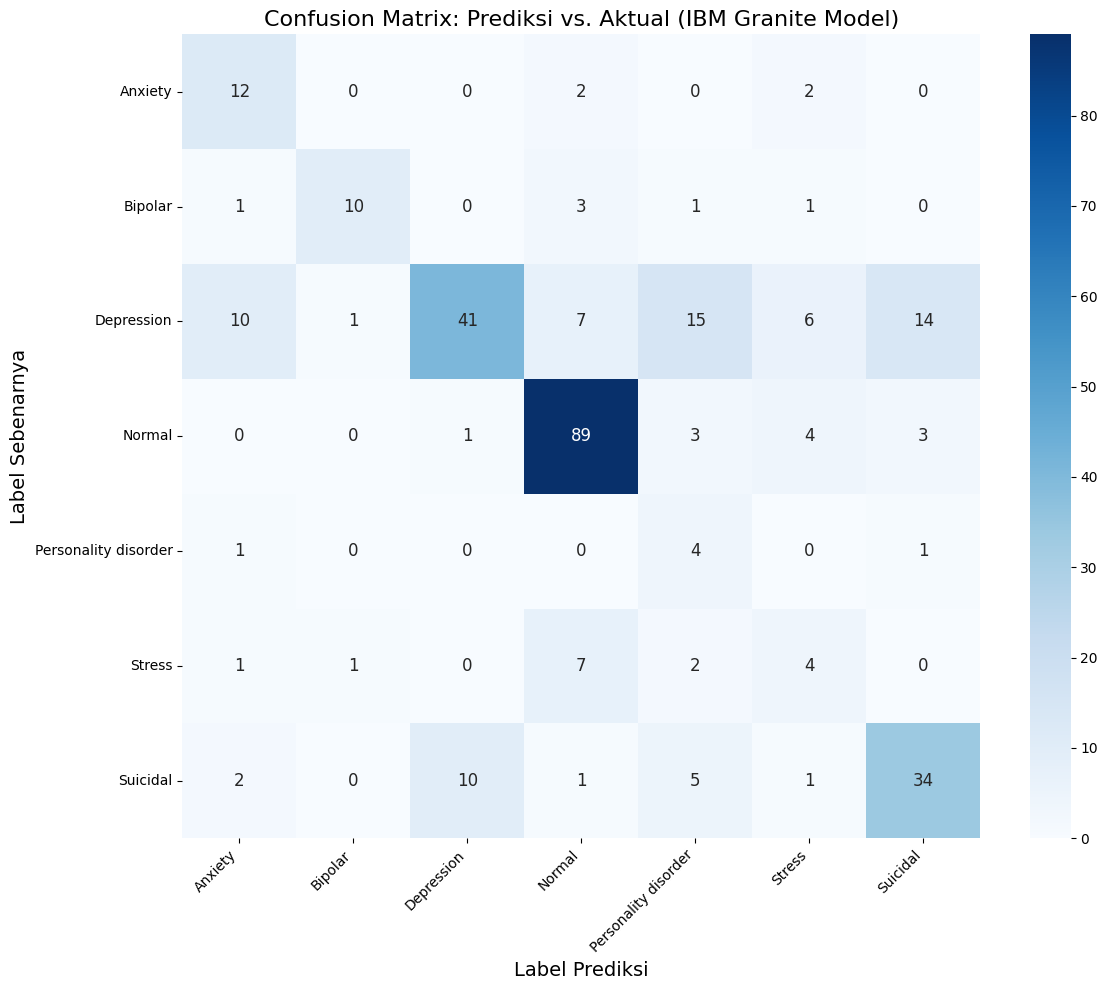


--- Insight Awal dari Confusion Matrix ---
Matrix menunjukkan jumlah prediksi benar (diagonal) dan salah (off-diagonal).
Perhatikan kelas-kelas yang sering tertukar, ini menunjukkan area tantangan model.


In [19]:
# Ambil true_labels yang sesuai dengan sampel yang diproses
true_labels_for_eval = y_test.iloc[:num_samples_to_process].tolist()

# Filter prediksi yang valid untuk evaluasi metrik
valid_true_labels = []
valid_predicted_labels = []

for tl, pl in zip(true_labels_for_eval, predicted_labels):
    if pl in unique_labels:
        valid_true_labels.append(tl)
        valid_predicted_labels.append(pl)

print(f"\nJumlah prediksi valid untuk evaluasi: {len(valid_predicted_labels)} dari {num_samples_to_process}.")

if len(valid_true_labels) > 0:
    print("\n--- Laporan Klasifikasi pada Sampel Testing Set ---")
    print(classification_report(valid_true_labels, valid_predicted_labels,
                                target_names=unique_labels, zero_division=0))

    print("\n--- Visualisasi Confusion Matrix ---")
    cm = confusion_matrix(valid_true_labels, valid_predicted_labels, labels=unique_labels)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels, yticklabels=unique_labels,
                annot_kws={"size": 12})
    plt.title('Confusion Matrix: Prediksi vs. Aktual (IBM Granite Model)', fontsize=16)
    plt.xlabel('Label Prediksi', fontsize=14)
    plt.ylabel('Label Sebenarnya', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\n--- Insight Awal dari Confusion Matrix ---")
    print("Matrix menunjukkan jumlah prediksi benar (diagonal) dan salah (off-diagonal).")
    print("Perhatikan kelas-kelas yang sering tertukar, ini menunjukkan area tantangan model.")
else:
    print("\nTidak ada prediksi valid yang cukup untuk menghasilkan laporan klasifikasi dan confusion matrix.")

## Langkah 7 : Ekstraksi Insight, Kesimpulan, dan Rekomendasi

Bagian ini menyajikan temuan kunci dan rekomendasi berdasarkan analisis data dan performa model.

7.1 Insight & Findings


---



 1. Data & Bahasa : Dataset terdiri dari 53,043 pernyataan berbahasa Inggris. Ditemukan 362 nilai hilang pada kolom 'statement' yang telah ditangani
 2. Imbalance Kelas : Terdapat ketidakseimbangan kelas yang signifikan. 'Normal' (16,351) dan 'Depression' (15,404) adalah mayoritas. Kelas minoritas meliputi 'Suicidal' (10,653), 'Anxiety' (3,888), 'Bipolar' (2,877), 'Stress' (2,669), dan 'Personality Disorder' (1,201). Imbalance ini menjadi tantangan utama bagi model.
 3. Performa Keseluruhan : Dengan Prompt Engineering (20 contoh Few-Shot berbahasa Inggris dan instruksi tegas), model IBM Granite mencapai akurasi 65% dan F1-score weighted 0.66 pada 300 sampel testing.
 4. Kinerja Per Kelas :
    * Baik: 'Normal' (F1: 0.85), 'Bipolar' (F1: 0.69), dan 'Suicidal' (F1: 0.66) menunjukkan kinerja yang cukup baik.
    * Cukup Baik (Recall Lebih Tinggi dari Precision): 'Anxiety' (F1: 0.57, Recall: 0.75) menunjukkan kemampuan deteksi yang baik, namun presisi rendah (0.46).
    * Sulit Dideteksi: 'Depression' (F1: 0.55, Recall: 0.43) masih sering terlewat. 'Stress' (F1: 0.29) dan 'Personality Disorder' (F1: 0.22) adalah kelas yang paling sulit diklasifikasikan.
 5. Pola Kesalahan (dari Confusion Matrix): Model sering kebingungan antara kategori yang memiliki ekspresi semantik serupa (misalnya, Anxiety vs Stress atau Depression). Kelas minoritas seperti Personality Disorder cenderung tersebar dan sering salah diprediksi sebagai kelas mayoritas.
 6. Efektivitas Prompt Engineering : Penerapan 20 contoh Few-Shot berbahasa Inggris dan instruksi prompt yang terdefinisi dengan baik terbukti krusial dalam membimbing model LLM, memungkinkan pemrosesan 300 sampel dengan output valid dan meningkatkan deteksi pada beberapa kategori minoritas.
 7. Batasan Pendekatan : Akurasi 65% mencerminkan batasan metode prompting LLM untuk domain yang kompleks dan data yang sangat tidak seimbang tanpa fine-tuning model yang mendalam.

\
7.2 Conclusion & Recommendations


---


 1. Kesimpulan :
    
    * Proyek ini berhasil membangun sistem klasifikasi status kesehatan mental menggunakan IBM Granite Model via Prompt Engineering.
    * Model menunjukkan kemampuan deteksi yang memadai pada kategori mayoritas ('Normal', 'Depression') dan beberapa kategori minoritas penting ('Suicidal', 'Bipolar'), namun masih menghadapi tantangan pada kelas yang sangat minoritas ('Personality Disorder', 'Stress', 'Anxiety') karena imbalance data.
    * Penggunaan AI (IBM Granite Model) melalui Prompt Engineering telah mendemonstrasikan potensi untuk analisis klasifikasi teks skala besar.
  
 2. Rekomendasi (Konkret, Actionable, Berdampak Nyata)

    * Untuk Pihak Terkait (Pemerintah/Organisasi Kesehatan Mental):
      * Model ini dapat berfungsi sebagai alat skrining awal di platform media sosial untuk mengidentifikasi individu yang berpotensi membutuhkan dukungan, terutama untuk 'Depression', 'Suicidal', dan 'Bipolar'.
      * Intervensi manusia tetap esensial untuk validasi dan penanganan kasus-kasus sensitif dan minoritas yang sulit dideteksi AI.
    * Untuk Peningkatan Model di Masa Depan (Rekomendasi Teknis):
      * Fine-tuning LLM: Untuk akurasi di atas 80-90%, diperlukan fine-tuning model LLM (misalnya, BERT-based) secara langsung pada dataset kesehatan mental ini.
      * Kualitas & Kuantitas Data: Mengumpulkan lebih banyak data berlabel yang jelas dan seimbang untuk kategori minoritas akan sangat meningkatkan kinerja model.
      * Model Spesifik Domain: Eksplorasi LLM yang sudah di-fine-tune sebelumnya pada domain klinis/kesehatan mental.
      * Teknik Ensemble: Menggabungkan beberapa model atau teknik klasifikasi untuk hasil yang lebih andal.
    * Dampak Potensial: Sistem deteksi berbasis AI memiliki potensi untuk mempercepat identifikasi individu berisiko dan mengalokasikan sumber daya dukungan kesehatan mental secara lebih efisien.